In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import warnings
import random
import pickle
import scipy
import os.path as osp

import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

from tqdm.notebook import tqdm

# $k$ optimization

### Roc1

In [2]:
res = """
4 0.672917 0.227101 0.0263188
8 0.779795 0.340687 0.0555327
12 0.813021 0.382774 0.065329
16 0.82026 0.397336 0.0712361
20 0.834776 0.408998 0.0725226
24 0.83391 0.415321 0.0744766
28 0.839543 0.420737 0.0753114
32 0.84156 0.426954 0.079717
36 0.841484 0.424818 0.0758483
40 0.846543 0.433617 0.0794761
"""

In [3]:
l = []
for line in res.splitlines():
    if line.strip():
        l.append([float(i) for i in line.split(' ')])
df_auc = pd.DataFrame(l, columns='k fam sfam fold'.split())

[6.59 2.2 ]


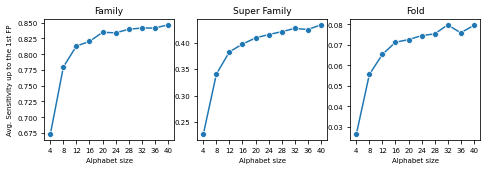

In [4]:
textwidth = 170  # mm

mm_per_inch = 25.4
golden_ratio = 1.618

w_inch = round((170 / mm_per_inch) - 0.1, 2)
h_inch = w_inch / golden_ratio
w_inch, h_inch

mw = 6.525 # golden_ratio = 1.618
plt.figure(figsize=(w_inch, 2.2))
#plt.suptitle('Area under ROC5 plot by alphabet size $k$')

#plt.rc('font', family='sans serif', serif='Times')
#plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('axes', labelsize=7)
plt.rc('axes', titlesize=9)

ylabel = 'Avg. Sensitivity up to the 1st FP' # 'Area under the ROC curve'
#ylabel = 'test'

ax = plt.subplot(131)
plt.title('Family')
sns.lineplot(data=df_auc, x='k', y='fam', marker='o')
plt.xticks(list(range(4, 40+1, 4)), list(range(4, 40+1, 4)))
#ax.label_outer()
#plt.xscale('log')
plt.ylabel(ylabel)
plt.xlabel('Alphabet size')

ax = plt.subplot(132)
plt.title('Super Family')
sns.lineplot(data=df_auc, x='k', y='sfam', marker='o')
plt.xticks(list(range(4, 40+1, 4)), list(range(4, 40+1, 4)))
plt.ylabel(None)
#plt.xscale('log')
#ax.label_outer()
plt.xlabel('Alphabet size')

ax = plt.subplot(133)
plt.title('Fold')
sns.lineplot(data=df_auc, x='k', y='fold', marker='o')
plt.xticks(list(range(4, 40+1, 4)), list(range(4, 40+1, 4)))
#plt.xscale('log')
#ax.label_outer()
plt.ylabel(None)
plt.xlabel('Alphabet size')

plt.tight_layout(pad=0.1)
print(plt.gcf().get_size_inches())
plt.savefig('3Di_k_optimization.pdf', dpi=400, transparent=True, pad_inches=0.0)  # , bbox_inches='tight'
plt.show()

# Cross-validation

In [5]:
!cat tmp/crossval_ref?.rocx | awk '(NR==1 || /^[^NAME]/)' > tmp/crossval_ref_all.rocx
!cat tmp/crossval_splitmodel?.rocx | awk '(NR==1 || /^[^NAME]/)' > tmp/crossval_splitmodel_all.rocx

In [6]:
!awk '{famsum+=$3; supfamsum+=$4; foldsum+=$5} END{print famsum/NR,supfamsum/NR,foldsum/NR}' tmp/crossval_ref_all.rocx

0.868966 0.508279 0.13231


In [7]:
!awk '{famsum+=$3; supfamsum+=$4; foldsum+=$5} END{print famsum/NR,supfamsum/NR,foldsum/NR}' tmp/crossval_splitmodel_all.rocx

0.864283 0.495354 0.131605


In [8]:
def rocx2coord(fn, colID):
    df = pd.read_csv(fn, header=0, sep='\t')
    dfsort = df.sort_values(by=colID, ascending=False)
    x, y, n = [], [], 1
    sumscore = 0.0
    for index,row in dfsort.iterrows():
        score = float(row[colID])
        qfraction = n / df.shape[0]
        x.append(min(score, 1))
        y.append(qfraction)
        n+=1
    return x, y

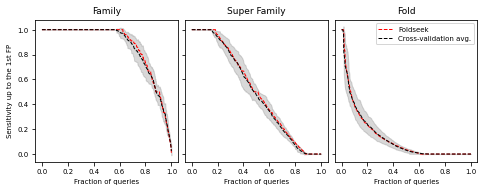

In [9]:
w_inch = 6.6
h_inch = 2.5 # 8.55

plt.rc('legend',fontsize=7)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('axes', labelsize=7)
plt.rc('axes', titlesize=9)
lw = 1

w = np.array([3135, 3706, 2219, 2100])  # num of PDBS per split
w = w / w.sum()

category = ["Family", "Super Family", "Fold"]
dfcol = ["FAM", "SFAM", "FOLD"]
style = ['-','--','-.']

fig, axs = plt.subplots(1,3, sharey=True)
fig.set_size_inches(w_inch, h_inch, forward=True)

for i, cls in enumerate(dfcol):
    qfracs, senss = [], []
    axs[i].set_title(category[i])
    for k in range(4):
        sens, qfrac = rocx2coord(f'tmp/crossval_splitmodel{k}.rocx', cls)        
        qfracs.append(qfrac)
        senss.append(sens)
        

    qfrac_all = np.sort(np.concatenate(qfracs))
    sens_interp = []
    for j in range(4):
        sens_interp.append(scipy.interpolate.interp1d(qfracs[j], senss[j], kind='linear', fill_value='extrapolate')(qfrac_all))
    sens_interp = np.stack(sens_interp)
    
    x_ref, y_ref = rocx2coord(f'tmp/crossval_ref_all.rocx', cls)
    axs[i].plot(y_ref, x_ref, label='Foldseek',color='red',linestyle='--',linewidth=lw)
    
    sens_w = (sens_interp.T @ w)
    axs[i].fill_between(qfrac_all, sens_w - sens_interp.std(axis=0), sens_w + sens_interp.std(axis=0), alpha=0.3, color='gray')    
    axs[i].plot(qfrac_all, sens_w, label='Cross-validation avg.',color='black',linestyle='--',linewidth=lw)

for ax in axs.flat:
    ax.set(ylabel="Sensitivity up to the 1st FP", xlabel="Fraction of queries")
for ax in axs.flat:
    ax.label_outer()
plt.legend()
plt.tight_layout(pad=0.1)
plt.savefig('3Di_crossval_SCOPe.pdf', dpi=400)
plt.show()